# WDUM - praca domowa 5
## Aleksander Malinowski | Damian Skowroński

### Wprowadzenie
Przeprowadzamy nienadzorowane uczenie maszynowe na zbiorze, [UrbanGB](https://archive.ics.uci.edu/ml/datasets/UrbanGB,+urban+road+accidents+coordinates+labelled+by+the+urban+center#), który przedstawia koordynaty wypadków samochodowych w miastach na terenie Wielkiej Brytanii. Zbiór ten jest okrojoną wersją zbioru z [Kaggle](https://www.kaggle.com/datasets/daveianhickey/2000-16-traffic-flow-england-scotland-wales).

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('urbanGB.txt', header = None, names = ['long','lat'])
df

,long,lat
0,-0.310990,53.7802
1,-3.112550,55.8706
2,-0.088533,51.3806
3,-0.326795,51.4476
4,-3.946530,51.6594
...,...,...
360172,-0.557803,53.2197
360173,-1.748430,52.4872
360174,-0.128844,51.5126
360175,-1.885640,52.4490


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360177 entries, 0 to 360176
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   long    360177 non-null  float64
 1   lat     360177 non-null  float64
dtypes: float64(2)
memory usage: 5.5 MB


Zbiór danych został przygotowany, więc jak się można było spodziewać nie ma tu brakujących danych. Warto zauważyć, że zbiór ma aż $360000$ obserwacji co sprawia, że nie każdy model będzie mógl zostać użyty, ze względu na duże wymagania pamięciowe i czasowe.

Odpowiednio mapując koordynaty ze zbioru danych otrzymujemy taki obrazek:

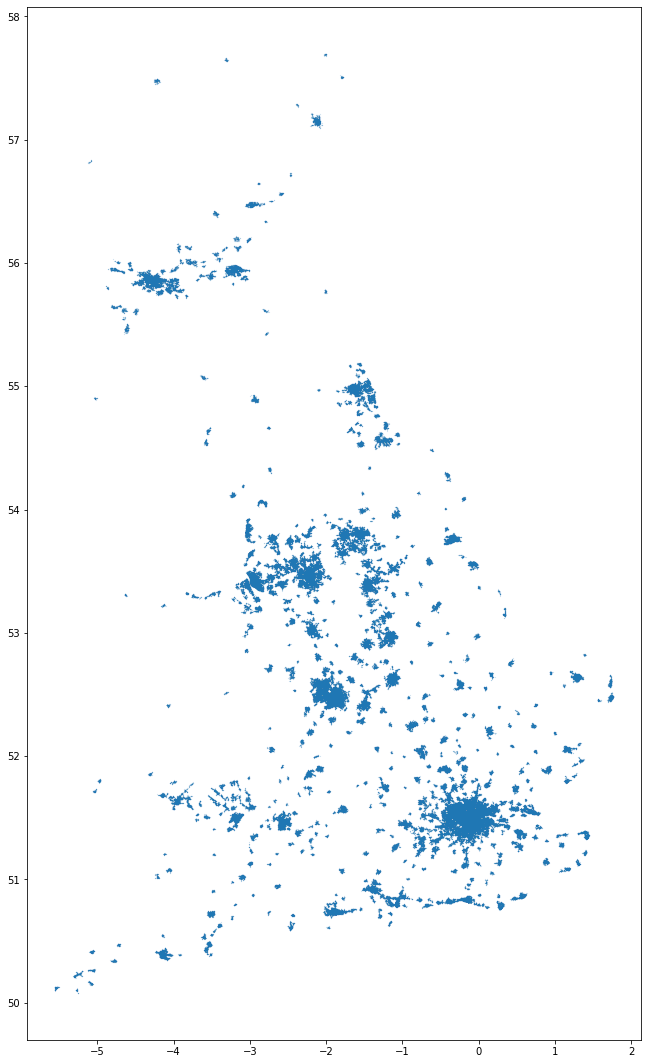

In [32]:
plt.figure(figsize=(5.5*2,9.5*2))
plt.scatter(x = df["long"], y = df["lat"],s=0.01, alpha= 0.75)

Z wykresu widać mniej więcej zarys Wielkiej Brytani z punktami skupienia w dużych miastach. Szczególnie duże skupienie jest w prawym dolnym rogu, co odpowiada Lonodynowi.

Potencjalnie więc celem tej pracy będzie stworzenie klastrów dobrze oddzielających te miasta. 

### Klasteryzacja
Przed wykonaniem klasteryzacji wykanujemy jeszcze zmniejszenie zmiennej *long* w skali $1.7$ co jest polecane przez autorów w sekcji *Attribute Information* na [zalinkowanej na wstępie stronie](https://archive.ics.uci.edu/ml/datasets/UrbanGB,+urban+road+accidents+coordinates+labelled+by+the+urban+center#).

In [33]:
df['long'] = df['long']/1.7

Wykonamy klasteryzację używając metod:
- k-means
- DBSCAN

Pozostałych metod dostępnych w sklearnie nie udało nam się odpalić z błędem, że potrzeba do tego prawie 1TB ramu. 


### k-means
Będziemy szukać odpowiedniej liczby klastrów używając *WCSS*. Nie udało nam się użyć miary *silhouette* , ponieważ nawet po godzinie liczenia nie dostaliśmy wyniku dla 10 klastrów. Wyniki przedstawimy na wykresach. 

W tym celu tworzymy funkcję.

In [34]:
from sklearn.cluster import KMeans

def kmeans_results(X,n_clusters):
    # fituje kmeans dla podanej liczby klastrów i zwraca wyniki w słowniku
    results = {}  
    for k in n_clusters:
        km = KMeans(n_clusters=k, random_state=0)
        km.fit(X)
        labels = km.predict(X)
        results[k] = {
            "wcss" : km.inertia_,
            # "silhouette" : silhouette_samples(X,labels, n_jobs = -1), #za długo się liczy na tak dużym zbiorze
            "labels" : labels,
            "centers" : km.cluster_centers_,
        }
    return results

km_res = kmeans_results(df,range(10,201,10))    # liczy okolo 15 minut

Szukamy liczby klastrów w dużym przedziale, od 10 do 200 z krokiem o 10, ponieważ zbiór jest bardzo duży, a samych miast w Wielkiej Brytanii jest ~70. (Chodzi o miejsca, które mają status *city*. Są też miejsca z dużą ilością mieszkańców, chociaż nadal mają status *town*, i pewnie też wiele z nich jest tu zawartych). 

Nasze wyniki prezentują się tak:

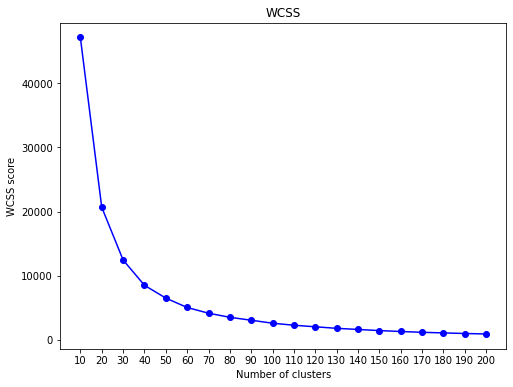

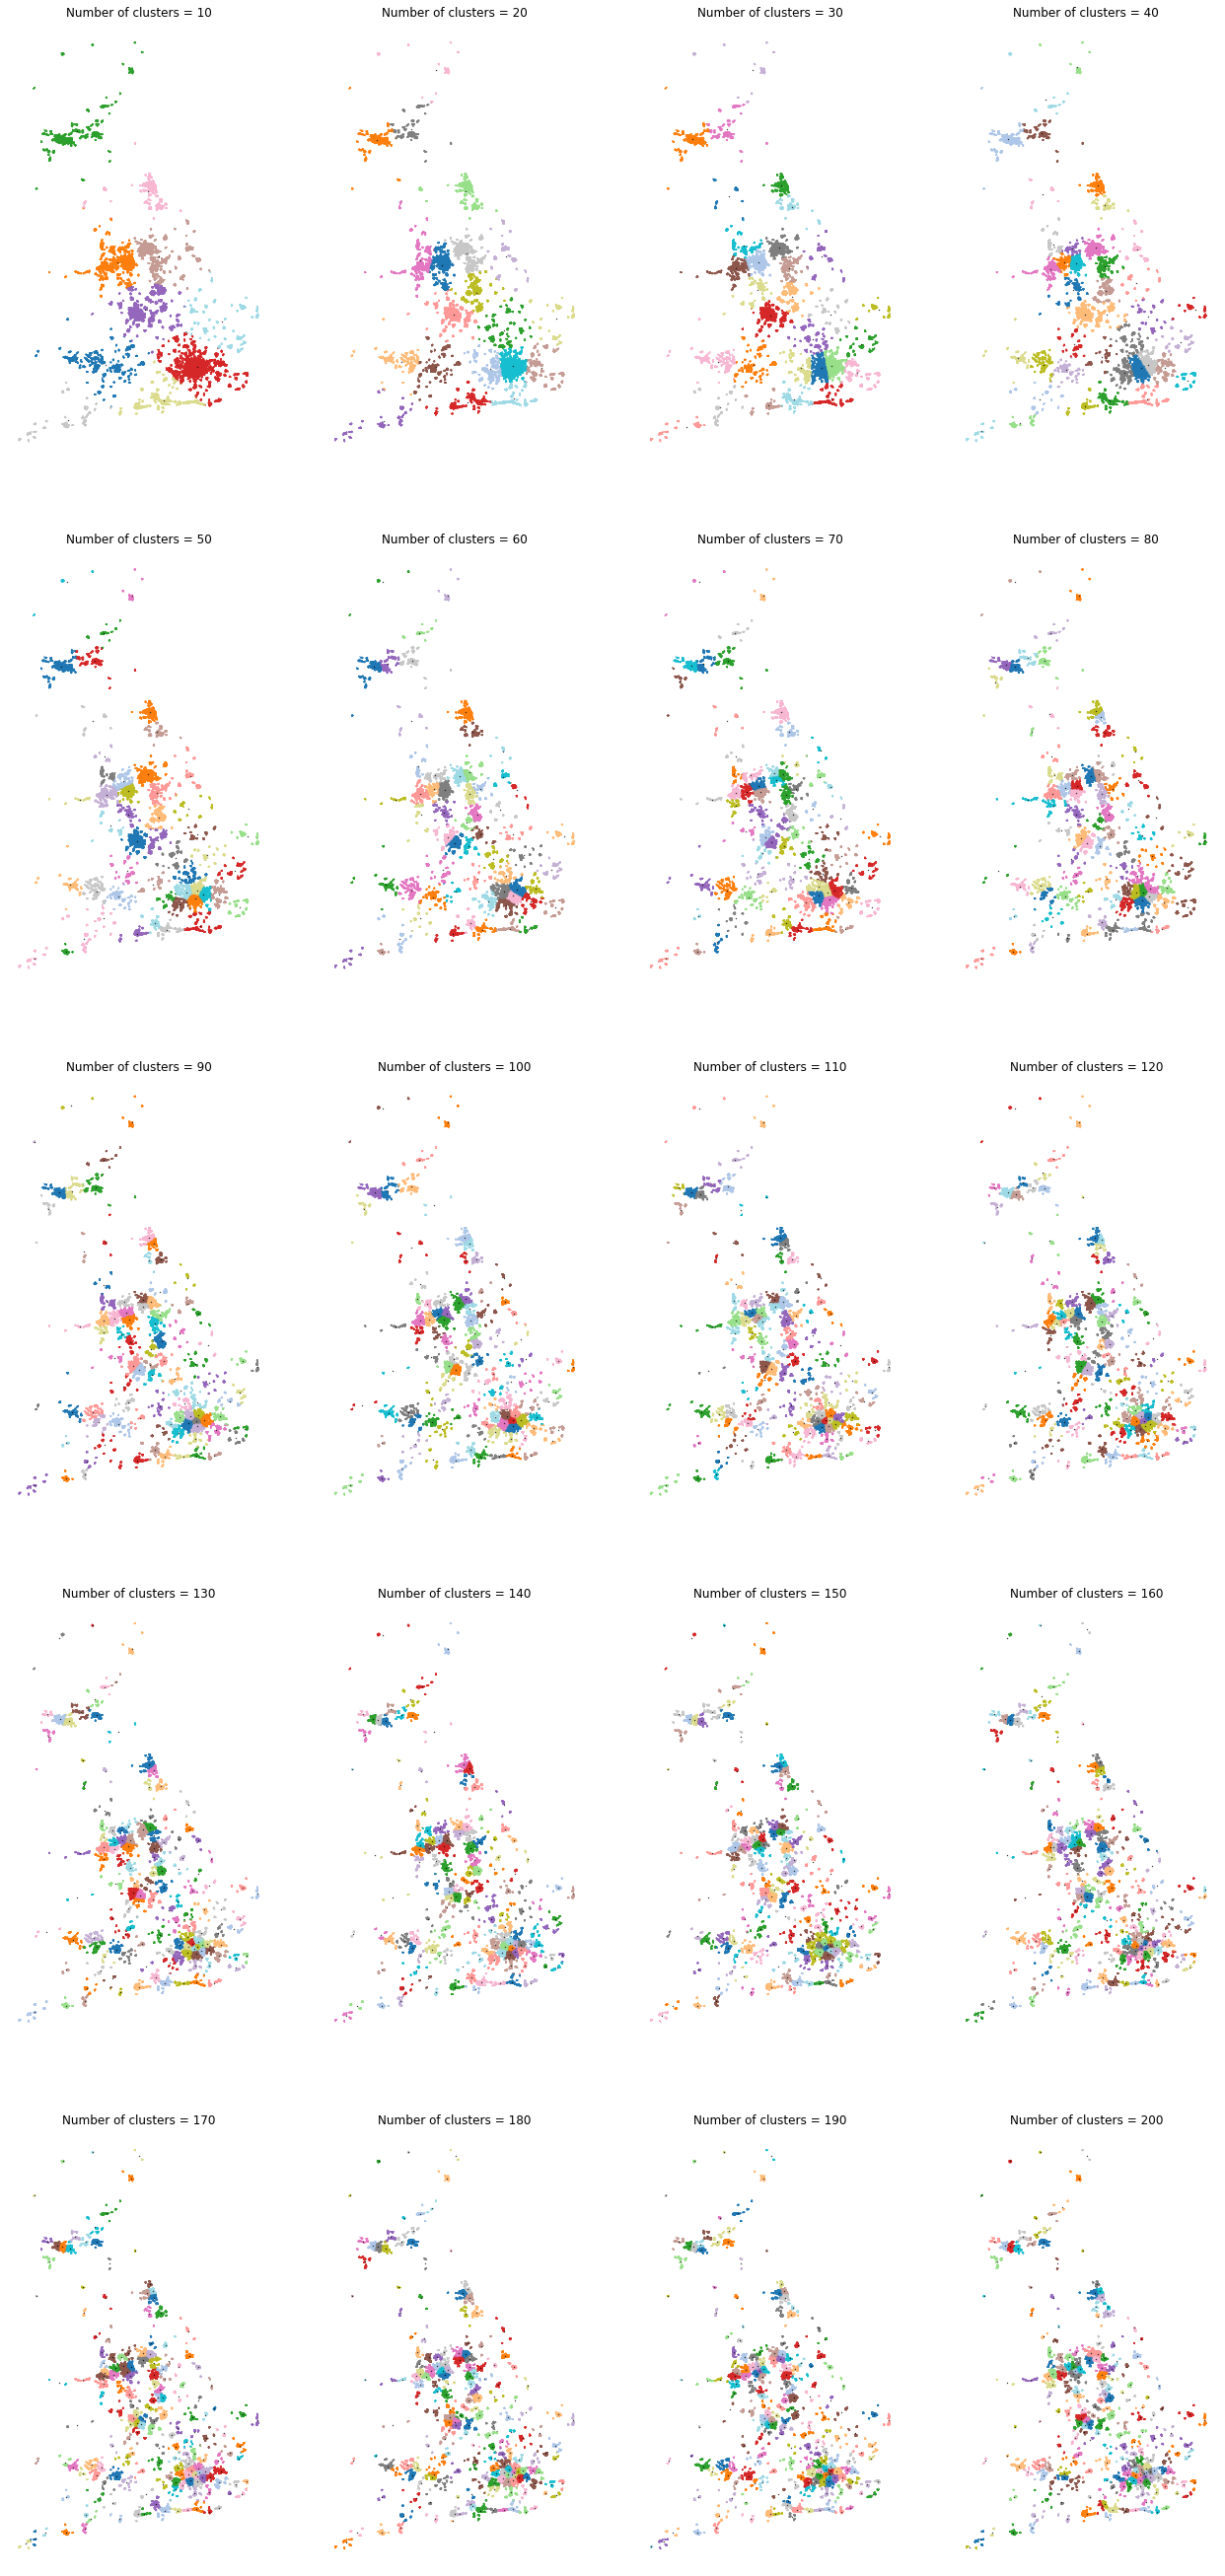

In [49]:
def plot_wcss(results):
    wcss_scores = []
    for k in results.keys():
        wcss_scores.append(results[k]['wcss'])
    plt.figure(figsize=(8,6))
    plt.plot(results.keys(),wcss_scores , 'bo-',)
    plt.xticks(np.array(list(results.keys())))
    plt.xlabel("Number of clusters")
    plt.ylabel("WCSS score")    
    plt.title("WCSS")

def plot_clusters(results,rows=1,cols=1,size = (5.5,9.5)):
    fig, ax = plt.subplots(rows, cols, figsize = size)
    [axi.set_axis_off() for axi in ax.ravel()];
    ks = np.array(list(results.keys())).reshape(ax.shape)
    for axi, i in zip(ax,ks):
        for axj, j in zip(axi,i):
            axj.scatter(df['long'], df['lat'], c=results[j]['labels'], s = 0.1, alpha=0.75, cmap = 'tab20')
            centers = results[j]['centers']
            axj.scatter(centers[:, 0], centers[:, 1], c='black', s=0.2, alpha=0.75, marker = 'x')
            axj.set_title(f"Number of clusters = {j}")
    
plot_wcss(km_res)
plot_clusters(km_res,5,4,(5.5*4,9.5*5))  

Patrząc na wykres *WCSS* łokieć dla liczby klastrów jest gdzieś w przedziale od $30$ do $65$. Jednak już teraz wydaje nam się, że metoda k-means nie jest dobra w tym przypadku (jeśli chcemy osiągnać podział na miasta), ponieważ dla małej liczby klastrów jest zbyt ogólnie i kilka miast, które widocznie są od siebie oddalone, jest branych do jednego klastra. Natomiast im więcej klastrów, tym rzeczywiście rozdzielane są od siebie mniejsze miasta, ale też duże miasta są dzielone na kilka klastrów.

Mimo tego, że wyniki nie wychodzą najlepsze to poszukamy, czegoś dobrego mniej więcej tam gdzie jest łokieć. Bierzemy liczbę klastrów w przedziale $30$ do $65$ z krokiem co $5$, i w podobny sposób przedstawiamy wyniki.

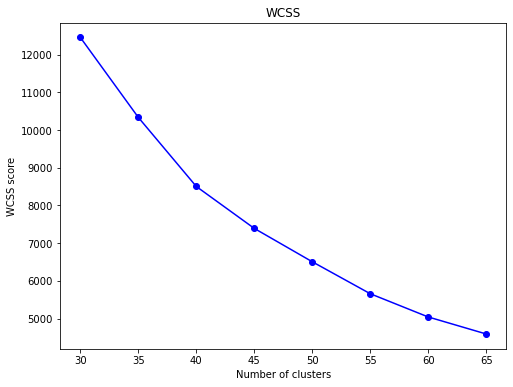

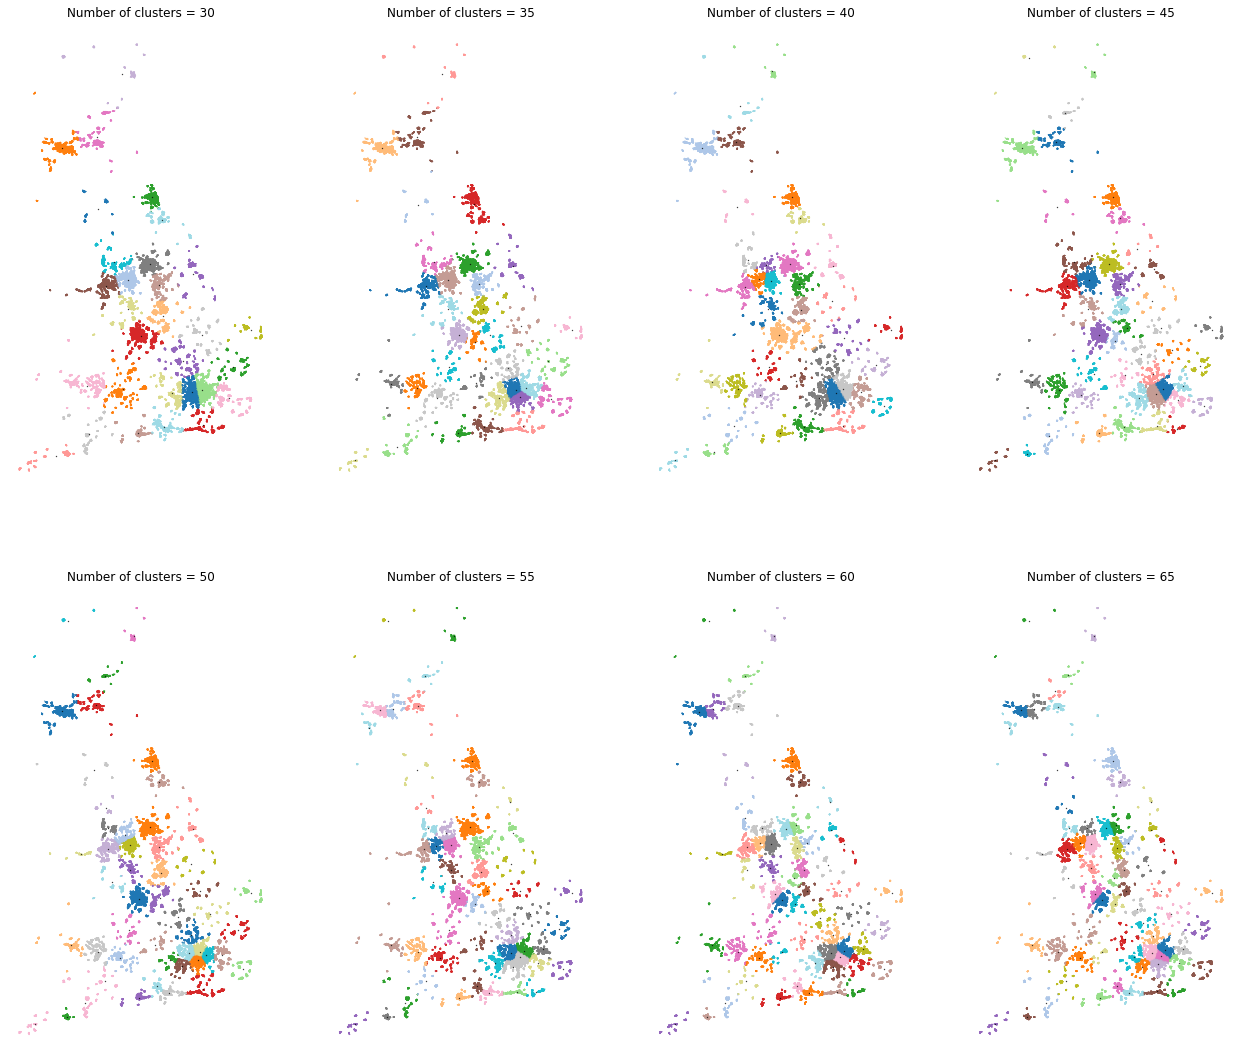

In [51]:
km_res_elbow = kmeans_results(df,range(30,66,5))  
plot_wcss(km_res_elbow)
plot_clusters(km_res_elbow,2,4,(5.5*4,9.5*2))  

Wychodzi na to, że odpowiednia liczba klastrów wg metryki *WCSS* wynosi około 40. Patrząc na wykresy punktów 40 wydaje się całkiem dobrym kompromisem pomiędzy rozbijaniem dużych skupisk punktów, a łączeniem mniejszych, trochę od siebie oddalonych.

### DBSCAN
Zobaczymy teraz jak będzie się sprawować metoda DBSCAN. W niej największe znaczenie ma wybór hiperparametru *eps*, który oznacza największą odległość pomiędzy punktami, aby były sąsiadami. Oprócz tego ważny jest też hiperparametr *min_samples* oznaczający minimalną ilość sąsiadów, aby ich grupa była klastrem. 

Co prawda to odchodzi trochę od tematu zadania, ponieważ mieliśmy wybierać sami ilość klastrów, a tu robi się to automatycznie. Usprawiedliwienie jest takie, że innych metod nie udawało nam się odpalać ze względu na wielkość zbioru danych. 

Po kilku próbach najlepszy wynik wyszedł dla następujących parametrów.  

In [55]:
from sklearn.cluster import DBSCAN

dbs = DBSCAN(eps = 0.1, min_samples=20, n_jobs = -1)
dbs.fit(df) #liczy ~20-25 minut
labels = dbs.labels_

Liczba klastrów wyszła:

In [56]:
len(set(labels))

107

Przedstawienie klastrów na scatterplocie:

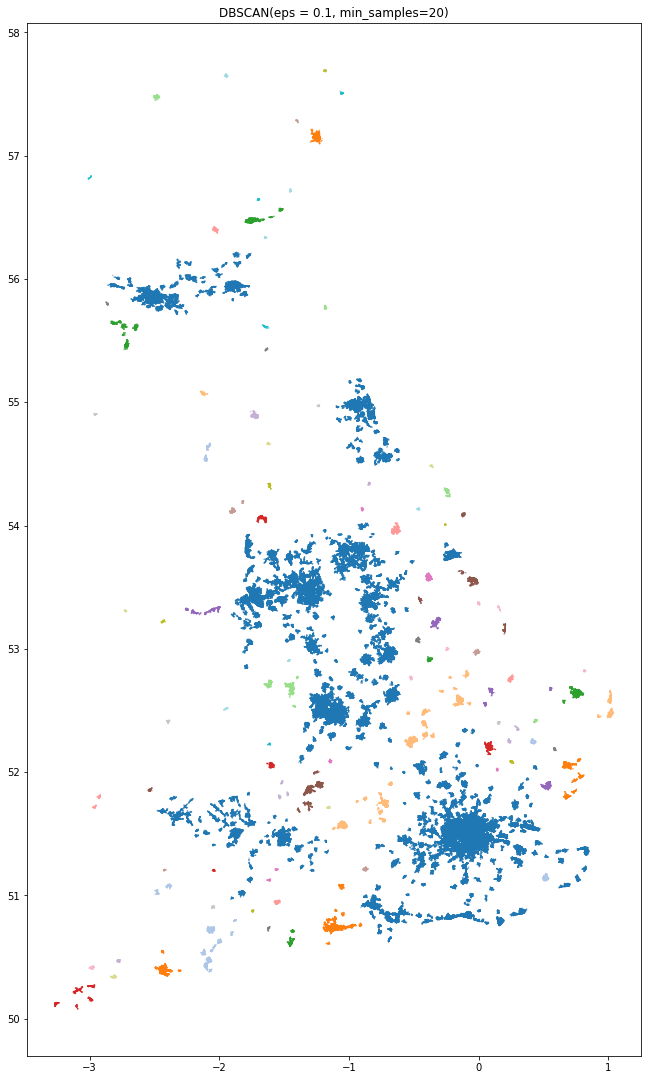

In [59]:
plt.figure(figsize=(5.5*2,9.5*2))
plt.scatter(df['long'], df['lat'], c=labels, s = 0.1, alpha=0.75, cmap='tab20')
plt.title("DBSCAN(eps = 0.1, min_samples=20)");

Wyniki się znacząco różnią od tych z k-means. Szczególnie widać, że duże klastry nie są rozdzielane co było oczekiwanym wynikiem. Nie do końca rozumiemy jak to się dzieje, że największe klastry zwykle sa kolorowane na wykresie na ten sam kolor mimo, że to są inne klastry. Oprócz tego warto zauważyć, że ten algorytm powinień usuwać "szum", czyli wszystkie obserwacje, które nie spełniły warunków postawionych przez hiperparametry *eps* i *min_samples*.

Aby temu zapobiec, można wykonać DBSCAN dla *min_samples* równego 1. 

Liczba klastrów = 107


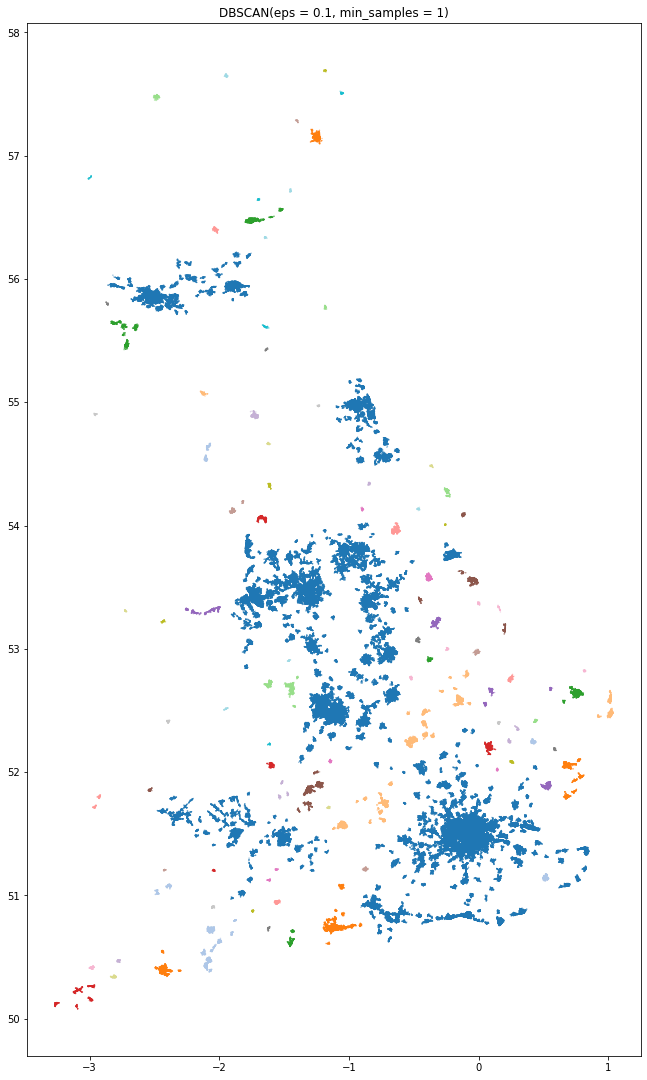

In [61]:
dbs = DBSCAN(eps = 0.1, min_samples = 1, n_jobs = -1)
dbs.fit(df) #liczy ~20 minut

labels = dbs.labels_
print("Liczba klastrów =",len(set(labels)))
plt.figure(figsize=(5.5*2,9.5*2))
plt.scatter(df['long'], df['lat'], c=labels, s = 0.1, alpha=0.75, cmap='tab20')
plt.title("DBSCAN(eps = 0.1, min_samples = 1)");

Liczba klastrów jest taka sama, czyli możliwe, że poprzedni model nie usuwał wcale obserwacji.

Teraz wykonamy DBSCANa na danych przedstawionych jako punkty odległe od siebie w kilometrach zamiast stopniach, a także zmienimy metrykę i algorytm, żeby DBSCAN działał na podstawie czegoś co się nazywa *great circle distance between points*. (robimy to wzorując się na [tym artykule](https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/))

In [52]:
kms_per_radian = 6371.0088
epsilon = 1.5 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=20, algorithm='ball_tree', metric='haversine').fit(np.radians(df)) #czas wykonania 15 sekund?
cluster_labels = db.labels_

Tym razem liczba klastrów jest dużo większa i wynosi:

In [53]:
len(set(cluster_labels))

447

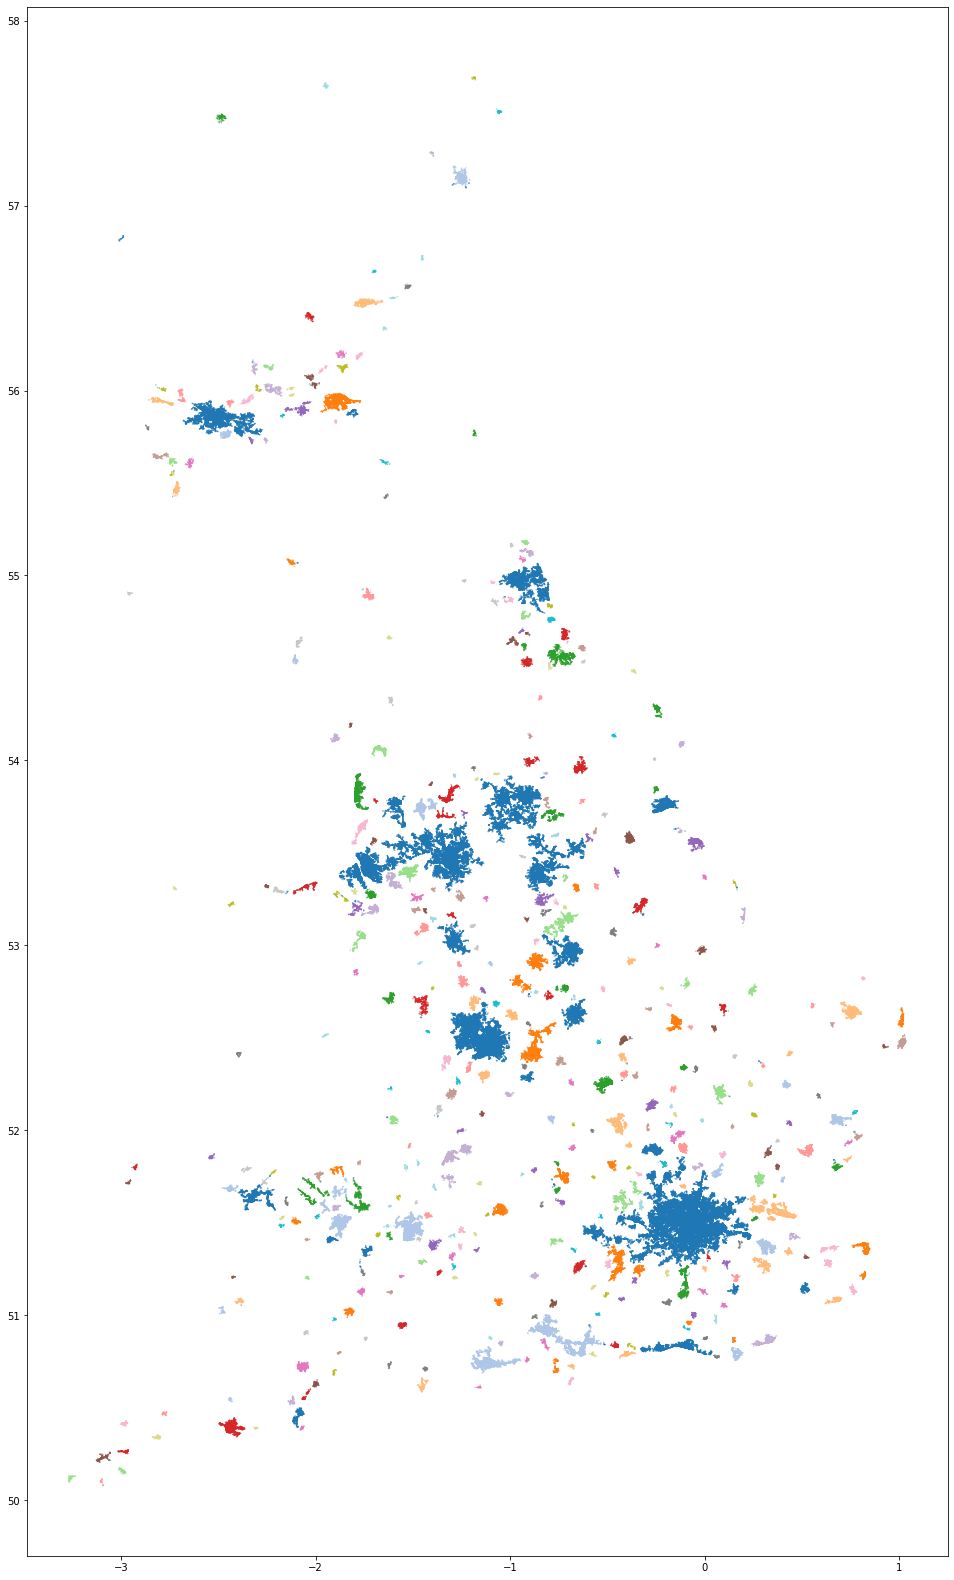

In [54]:
plt.figure(figsize=(5.5*3,9.5*3))
plt.scatter(df['long'], df['lat'], c=cluster_labels, s = 0.1, alpha=0.75, cmap = 'tab20')

Naszym zdaniem ten wynik wygląda najlepiej do tej pory, a dodatkowo czas wykonania też był najszybszy.

### Podsumowanie
W naszym przypadku okazało się, że metoda k-means mimo, że bardzo szybka to nie jest najlepszym rozwiązaniem dla danych geograficznych. Dużo lepszym rozwiązaniem jest użycie DBSCANa.